In [ ]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

In [2]:
import torch
import pickle
from dataloaders import get_data_loaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_gLRI import Bipartite_Attention as Model
import numpy as np
import matplotlib.colors as colors
from numpy.linalg import inv
from icecream import ic

In [645]:
def get_approximate_radii(track_vector):
    tracks_info = track_vector[:, :15]
    good_hits = np.any(tracks_info.reshape(tracks_info.shape[0], 5, 3) != 0, axis=-1)
    n_hits = np.sum(good_hits, axis=-1)
    x_indices = [3*j for j in range(5)]
    y_indices = [3*j+1 for j in range(5)]
    r = np.zeros((tracks_info.shape[0], 1))
    centers = np.zeros((tracks_info.shape[0], 2))
    for n_hit in range(3, 5 + 1):
        complete_tracks = tracks_info[n_hits == n_hit]
        hit_indices = good_hits[n_hits == n_hit]
        if complete_tracks.shape[0] == 0:
            continue

        A = np.ones((complete_tracks.shape[0], n_hit, 3))
        x_values = complete_tracks[:, x_indices]
        x_values = x_values[hit_indices].reshape(complete_tracks.shape[0], n_hit)

        y_values = complete_tracks[:, y_indices]
        y_values = y_values[hit_indices].reshape(complete_tracks.shape[0], n_hit)
        A[:, :, 0] = x_values
        A[:, :, 1] = y_values

        y = - x_values**2 - y_values**2
        y = y.reshape((y.shape[0], y.shape[1], 1))
        AT = np.transpose(A, axes=(0, 2, 1))
        c = matmul_3D(matmul_3D(inv(matmul_3D(AT, A)), AT), y)
        r[n_hits == n_hit] == 1
        r[n_hits == n_hit] = np.sqrt(c[:, 0]**2 + c[:, 1]**2 - 4*c[:, 2])/200
        centers[n_hits == n_hit] = np.concatenate([-c[:, 0]/2, -c[:, 1]/2], axis=-1)
    #test = get_approximate_radius(tracks_info, n_hits == 5)
    #assert np.allclose(test, r[n_hits == 5])

    return r, centers, n_hits

def matmul_3D(A, B):
    return np.einsum('lij,ljk->lik', A, B)

def decode(n):
    vectors = ['e_z', 'e_t', 'e_p']
    if n == 0:
        return '0'
    nums = []
    while n:
        n, r = divmod(n, 3)
        nums.append(vectors[r])
    return ', '.join(nums)

In [4]:
# α=0.3
config_file_path = 'train_results/biatt-glri/experiment_2023-02-11_03:56:54/config.pkl'
#config_file_path = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [5]:
DEVICE = 'cuda:0'
# α=0.3
checkpoint_file = 'train_results/biatt-glri/experiment_2023-02-11_03:56:54/checkpoints/model_checkpoint_012.pth.tar'
#checkpoint_file = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/checkpoints/model_checkpoint_011.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

Bipartite_Attention(
  (interpreter): Bipartite_Attention(
    (_layers): ModuleList(
      (0): Bipartite_Layers(
        (enc): ModuleList(
          (0): Masked_SAB(
            (mab): Masked_MAB(
              (fc_q): Linear(in_features=30, out_features=64, bias=True)
              (fc_k): Linear(in_features=30, out_features=64, bias=True)
              (fc_v): Linear(in_features=30, out_features=64, bias=True)
              (fc_o): Linear(in_features=64, out_features=64, bias=True)
              (ln0): Masked_LayerNorm(
                (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              )
              (ln1): Masked_LayerNorm(
                (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              )
            )
          )
          (1): Masked_SAB(
            (mab): Masked_MAB(
              (fc_q): Linear(in_features=64, out_features=64, bias=True)
              (fc_k): Linear(in_features=64, out_features=64, bias=True)
              (fc_

In [6]:
dconfig = config['data']
dconfig['use_trigger'] = True
dconfig['use_nontrigger'] = False
train_data, val_data, test_data = get_data_loaders(**dconfig)

In [88]:
# Calculate the centers
rs = []
cs = []
event_hits = []
momentums = []
origin_vertices = []
tangents = []
tracks = []
sigmas = []
good_hits = []
tt_tracks = []
all_n_tracks = []
vs = []
n_hits = []

In [89]:
N_BATCHES = 100
for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1
        
    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)
    
    _, pred_sigmas, valid_hits = model(track_vector, mask)
    all_n_tracks.extend(batch.n_tracks.detach().cpu().numpy())
    #momentums.extend(batch.momentums.detach().cpu().numpy())
        
    for i, (track, momentum, origin_vertex, n_tracks) in enumerate(zip(batch.track_vector, batch.momentums, batch.origin_vertices, batch.n_tracks)):
        r, c, n = get_approximate_radii(track[:n_tracks].detach().cpu().numpy())
        n_hits.append(n)
        event_hits.append(track[:n_tracks, :15].reshape(n_tracks, 5, 3).detach().cpu().numpy())
        rs.append(r)
        cs.append(c)
        origin_vertices.append(origin_vertex[:n_tracks].detach().cpu().numpy())
        momentums.append(momentum[:n_tracks].detach().cpu().numpy())
        tracks.append(track[:n_tracks])
        x = event_hits[-1][..., 0]
        y = event_hits[-1][..., 1]
        c_x = cs[-1][..., 0]
        c_y = cs[-1][..., 1]
        v = np.stack([(x - np.expand_dims(c_x, -1)), (y - np.expand_dims(c_y, -1)), np.zeros(y.shape)], axis=-1)
        vs.append(v/np.expand_dims(np.linalg.norm(v, axis=-1), -1))
        z = np.array([0, 0, 1]).reshape(1, 1, -1)
        perp = np.cross(v, z)
        perp /= np.expand_dims(np.linalg.norm(perp, axis=-1), -1)
        tangents.append(perp)
        tt_tracks.append(is_trigger_track[i][:n_tracks].repeat(1, 5).detach().cpu().numpy())
        good_hits.append(valid_hits[i][:n_tracks].detach().cpu().numpy())
        sigmas.append(pred_sigmas[i][:n_tracks].detach().cpu().numpy())
n_tracks = all_n_tracks

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2010143/1470724057.py:30: RuntimeWarning: invalid value encountered in divide
  vs.append(v/np.expand_dims(np.linalg.norm(v, axis=-1), -1))
/tmp/ipykernel_2010143/1470724057.py:33: RuntimeWarning: invalid value encountered in divide
  perp /= np.expand_dims(np.linalg.norm(perp, axis=-1), -1)


In [62]:
tangents[0][0, 1] @ vs[0][0, 1]

0.0

In [60]:
vs[0][0, 0]

array([0.51555342, 0.85685744, 0.        ])

In [76]:
for i, v in enumerate(vs):
    if np.any(v[..., -1]):
        print(i, v)
        break

2 [[[ 0.87577598  0.48271776  0.        ]
  [ 0.87316974  0.48741626  0.        ]
  [ 0.87127587  0.4907936   0.        ]
  [ 0.86145442  0.50783489  0.        ]
  [ 0.85628078  0.51651062  0.        ]]

 [[ 0.21612466  0.97636578  0.        ]
  [        nan         nan         nan]
  [        nan         nan         nan]
  [        nan         nan         nan]
  [        nan         nan         nan]]

 [[-0.61693026 -0.78701782  0.        ]
  [-0.62406094 -0.78137567  0.        ]
  [-0.62870594 -0.77764313  0.        ]
  [-0.65643323 -0.75438413  0.        ]
  [-0.59793504 -0.80154456  0.        ]]

 [[-0.95836345 -0.2855512   0.        ]
  [-0.95927166 -0.28248519  0.        ]
  [-0.96020402 -0.27929954  0.        ]
  [-0.96454811 -0.26390709  0.        ]
  [-0.96741164 -0.25320884  0.        ]]

 [[-0.62503223  0.78059894  0.        ]
  [-0.62696411  0.77904814  0.        ]
  [-0.63022326  0.77641396  0.        ]
  [-0.64058492  0.76788734  0.        ]
  [-0.64643784  0.76296666  0.

In [83]:
~np.any(np.isnan(vs[2]), axis=-1)

array([[ True,  True,  True,  True,  True],
       [ True, False, False, False, False],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True, False, False,  True, False],
       [ True,  True, False, False, False],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [84]:
good_hits[2]

array([[ True,  True,  True,  True,  True],
       [ True, False, False, False, False],
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True],
       [ True,  True,  True,  True,  True],
       [ True, False, False,  True, False],
       [ True,  True, False, False, False],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [98]:
n_hits[0].shape

(5,)

In [99]:
good_hits[0].shape

(5, 5)

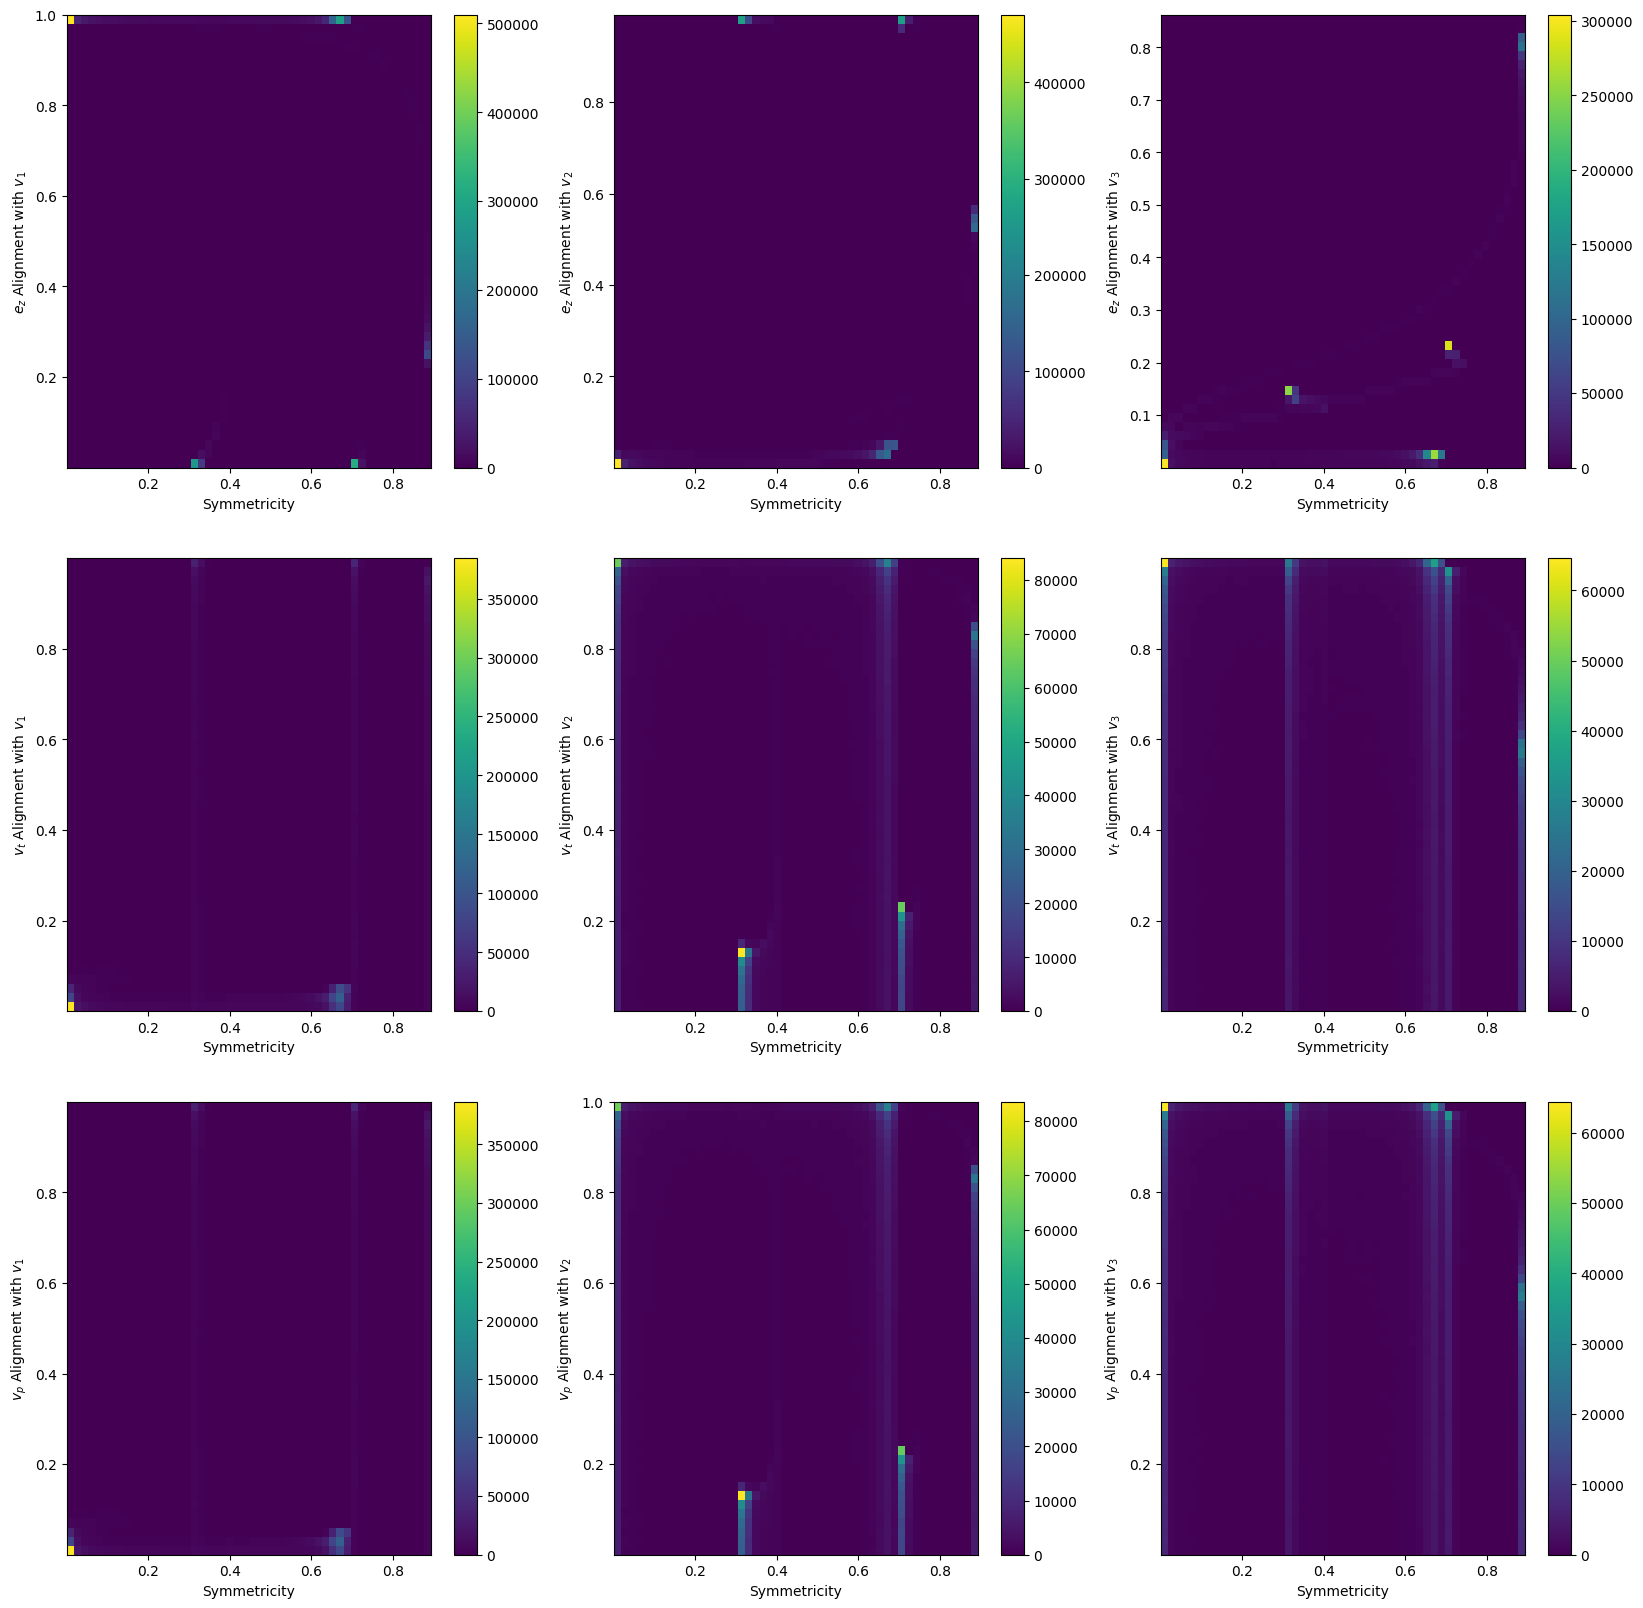

In [229]:
zs = [np.zeros(v.shape) for v in vs]
for z in zs:
    z[..., 2] = 1
all_coefficients = []
all_eigenvectors = []
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, (label, hypothesis) in enumerate(zip(('e_z', 'v_t', 'v_p'), (zs, tangents, vs))):
    for j in range(3):
        alignments = []
        symmetricities = []
        test_eigenvectors = []
        for track, sigma, momentum, hits_mask, trigger_mask, n_hit in zip(tracks, sigmas, hypothesis, good_hits, tt_tracks, n_hits):
            #print(sigma.shape)
            #m = np.repeat(np.expand_dims(momentum, 1), 5, axis=1).reshape(-1, 3)
            n_hit = (np.expand_dims(n_hit, -1).repeat(5, -1)).reshape(-1)
            m = momentum.reshape(-1, 3)
            #good_m = np.any(m != 0, axis=-1)
            hits_mask = hits_mask.reshape(-1)
            trigger_mask = trigger_mask.reshape(-1)
            mask = hits_mask 
            all_hits = track[..., :15].reshape(-1, 3)
            hits = all_hits[mask]
            m = m[mask]
            assert not np.any(np.isnan(m))
            sigma = sigma.reshape(-1, 3, 3)[mask]
            eigenvalues, eigenvectors = np.linalg.eig(sigma)

            m /= np.expand_dims(np.linalg.norm(m, axis=-1), -1)
            alignment = np.einsum('hf,hfi->hi', m, eigenvectors)
            preferred_direction = np.expand_dims(np.argsort(eigenvalues, axis=-1)[..., -(j+1)], -1)
            alignments.append(np.take_along_axis(alignment, preferred_direction, -1))
            symmetricities.append(np.prod(eigenvalues/np.expand_dims(np.max(eigenvalues, axis=-1), -1), -1))
            preferred = np.expand_dims(preferred_direction, -1).repeat(3, -1)
            test_eigenvectors.append(np.take_along_axis(eigenvectors, preferred, 1))
            #test_eigenvectors.append(eigenvectors[np.argsort(eigenvalues, axis=-1)[..., ::-1]])
        alignments = np.concatenate(alignments, axis=0)
        symmetricities = np.concatenate(symmetricities, axis=0)
        h = axes[i, j].hist2d(np.squeeze(symmetricities), np.squeeze(np.abs(alignments)), bins=50)
        all_coefficients.append(alignments)
        axes[i, j].set_xlabel('Symmetricity')
        axes[i, j].set_ylabel(f'${label}$ Alignment with $v_{j+1}$')
        all_eigenvectors.append(np.concatenate(test_eigenvectors, axis=0))
        fig.colorbar(h[3], ax=axes[i, j])

all_coefficients = np.concatenate(all_coefficients, axis=-1)
all_coefficients = all_coefficients.reshape(-1, 3, 3).transpose(1, 2, 0)

In [330]:
zs[0].shape

(5, 5, 3)

In [466]:
all_coefficients = []
all_eigenvectors = []
all_symetricities = []
all_bases = []
all_eigenvalues = []
all_nhits = []
#all_symmetricities = []
for z, tangent, v, sigma, hits_mask, n_hit in zip(zs, tangents, vs, sigmas, good_hits, n_hits):
    hits_mask = hits_mask.reshape(-1)
    n_hit = np.expand_dims(n_hit, -1).repeat(5, -1).reshape(-1)[hits_mask]
    z = z.reshape(-1, 3)[hits_mask]
    tangent = tangent.reshape(-1, 3)[hits_mask]
    v = v.reshape(-1, 3)[hits_mask]
    sigma = sigma.reshape(-1, 3, 3)[hits_mask] # Check if should be transposed. (probably not as sigma should be symmetric)
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    # eigenvectors: (hit, feature, eigenvector)
    basis = np.stack([z, tangent, v], axis=-1) # Stack them in the column.
    # basis: (hit, feature, basis vector)
    coefficients = np.einsum('hfb,hfe->heb', basis, eigenvectors)
    all_coefficients.extend(coefficients)
    all_eigenvectors.extend(eigenvectors)
    all_bases.extend(basis)
    all_eigenvalues.extend(eigenvalues)
    all_nhits.extend(n_hit)
all_coefficients = np.stack(all_coefficients, axis=0)
all_eigenvectors = np.stack(all_eigenvectors, axis=0)
all_bases = np.stack(all_bases, axis=0)
all_eigenvalues = np.stack(all_eigenvalues, axis=0)
all_symmetricities = np.prod(all_eigenvalues, axis=-1)/np.max(all_eigenvalues, -1)**3
all_nhits = np.array(all_nhits)


In [478]:
directions = np.argsort(all_eigenvalues, axis=-1)

In [492]:
directionally_sorted = np.take_along_axis(all_coefficients, np.expand_dims(directions, -1), axis=1)

In [502]:
highest_base = np.argmax(np.abs(directionally_sorted), axis=-1)

In [510]:
np.mean(highest_base[..., -1] == 2)

0.19586869895451914

In [514]:
np.sum((all_symmetricit) == 2)

NameError: name 'all_n_hits' is not defined

In [522]:
np.sum(all_nhits <= 3)/all_nhits.shape[0]

0.0389009642401391

In [523]:
FIRST_MODE_START, FIRST_MODE_END = (0, 0.017899131402373314)
SECOND_MODE_START, SECOND_MODE_END = (0.26818594336509705, 0.3575730323791504)
THIRD_MODE_START, THIRD_MODE_END = (0.6257343888282776, 0.7151214480400085)

In [586]:
sorted_eigenvalues = np.sort(all_eigenvalues, axis=-1)

In [ ]:
sorte

[0.01, 50.08, 49.9, 0.01]
17.341387549146717


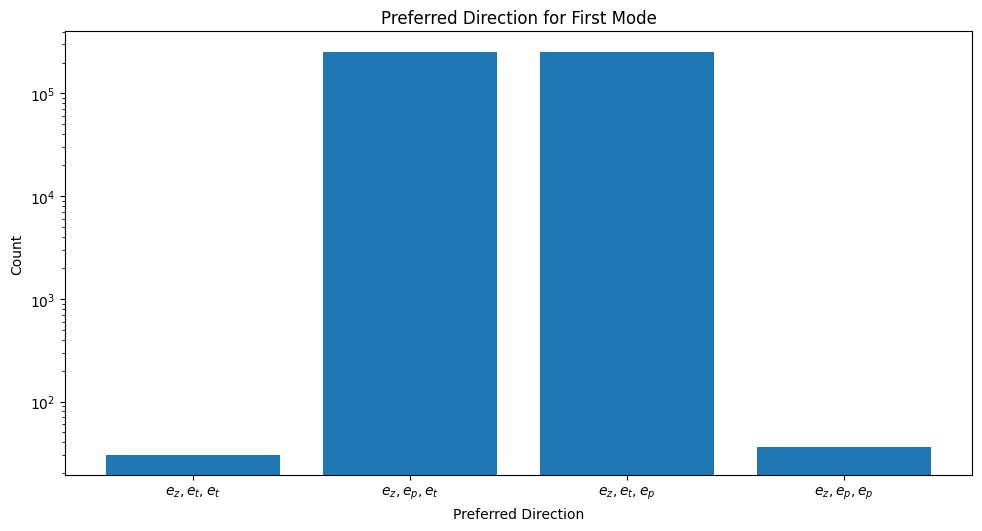

In [625]:
mask = (all_symmetricities >= FIRST_MODE_START) & (all_symmetricities <= FIRST_MODE_END)
dist = np.sum(highest_base[mask] * np.array([3**2, 3**1, 3**0]), axis=-1)
keys = dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))
x = [f'${keys[k]}$' for k in sorted(keys.keys())]
heights = [np.sum(dist == k) for k in sorted(keys.keys())]
plt.figure(figsize=(10, 5))
plt.bar(x, heights)
plt.tight_layout()
plt.yscale('log')
plt.title('Preferred Direction for First Mode')
plt.xlabel('Preferred Direction')
plt.ylabel('Count')
print([round(x, 2) for x in np.array(heights)/np.sum(heights) * 100])
print(100*np.sum(mask)/all_symmetricities.shape[0])

24.70146252464516


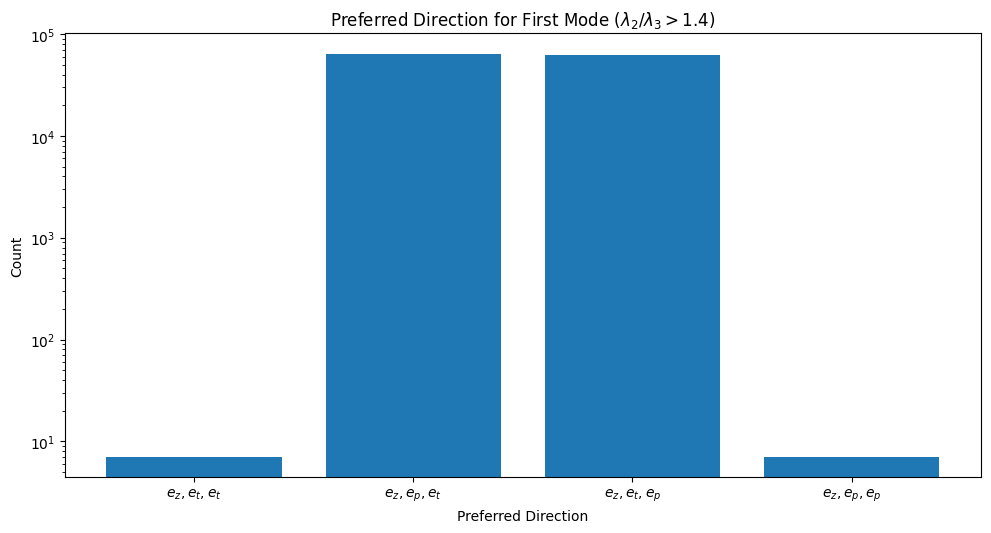

In [623]:
mask = (all_symmetricities >= FIRST_MODE_START) & (all_symmetricities <= FIRST_MODE_END) & (sorted_eigenvalues[:, 1]/sorted_eigenvalues[:, 0] > 1.4)
dist = np.sum(highest_base[mask] * np.array([3**2, 3**1, 3**0]), axis=-1)
keys = dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))
x = [f'${keys[k]}$' for k in sorted(keys.keys())]
heights = [np.sum(dist == k) for k in sorted(keys.keys())]
plt.figure(figsize=(10, 5))
plt.bar(x, heights)
plt.tight_layout()
plt.yscale('log')
plt.title('Preferred Direction for First Mode ($λ_2/λ_3 > 1.4$)')
plt.xlabel('Preferred Direction')
plt.ylabel('Count')
print(100*np.sum(mask)/np.sum((all_symmetricities >= FIRST_MODE_START) & (all_symmetricities <= FIRST_MODE_END)))

In [ ]:
print(np.su)

In [553]:
dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))

{12: 'e_t, e_t, e_z',
 15: 'e_t, e_p, e_z',
 21: 'e_p, e_t, e_z',
 24: 'e_p, e_p, e_z'}

[0.03, 43.5, 0.02, 6.46, 43.37, 0.03, 6.56, 0.02]
15.289583328372025


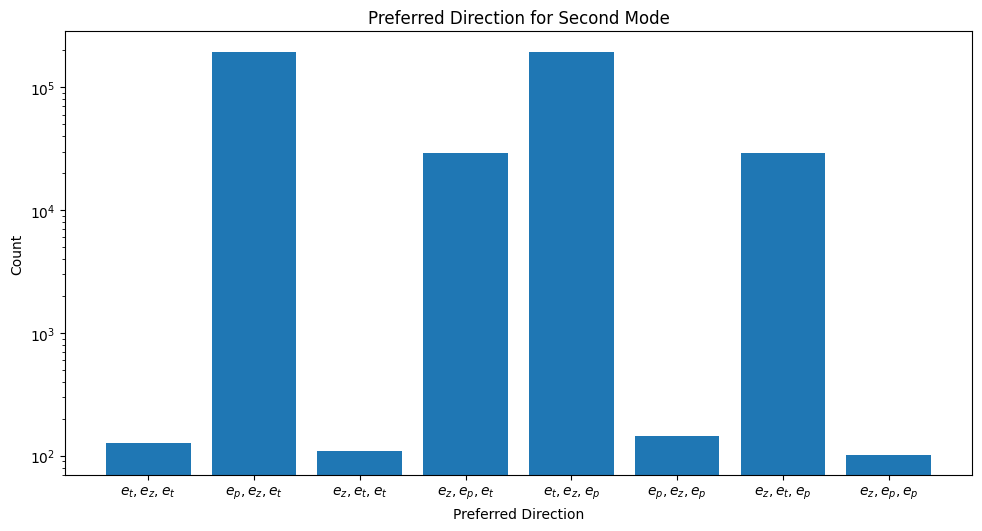

In [626]:
mask = (all_symmetricities >= SECOND_MODE_START) & (all_symmetricities <= SECOND_MODE_END)
dist = np.sum(highest_base[mask] * np.array([3**2, 3**1, 3**0]), axis=-1)
keys = dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))
x = [f'${keys[k]}$' for k in sorted(keys.keys())]
heights = [np.sum(dist == k) for k in sorted(keys.keys())]
plt.figure(figsize=(10, 5))
plt.bar(x, heights)
plt.tight_layout()
plt.yscale('log')
plt.title('Preferred Direction for Second Mode')
plt.xlabel('Preferred Direction')
plt.ylabel('Count')
print([round(x, 2) for x in np.array(heights)/np.sum(heights) * 100])
print(100*np.sum(mask)/all_symmetricities.shape[0])

[0.03, 16.35, 0.05, 33.8, 16.22, 0.03, 33.48, 0.05]
32.97256969333673
13.372465863082187


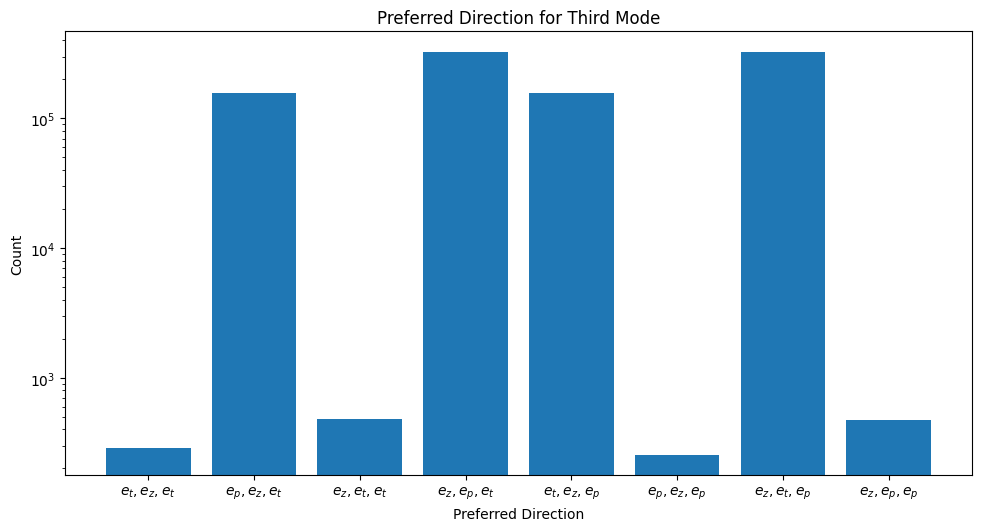

In [631]:
mask = (all_symmetricities >= THIRD_MODE_START) & (all_symmetricities <= THIRD_MODE_END)
dist = np.sum(highest_base[mask] * np.array([3**2, 3**1, 3**0]), axis=-1)
keys = dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))
x = [f'${keys[k]}$' for k in sorted(keys.keys())]
heights = [np.sum(dist == k) for k in sorted(keys.keys())]
plt.figure(figsize=(10, 5))
plt.bar(x, heights)
plt.tight_layout()
plt.yscale('log')
plt.title('Preferred Direction for Third Mode')
plt.xlabel('Preferred Direction')
plt.ylabel('Count')
print([round(x, 2) for x in np.array(heights)/np.sum(heights) * 100])
print(100*np.sum(mask)/all_symmetricities.shape[0])
print(100*np.sum(all_symmetricities >= 0.8)/all_symmetricities.shape[0])

In [630]:
np.max(all_symmetricities)

0.8939203

[0.05, 50.17, 49.74, 0.04]
64.94459347915807


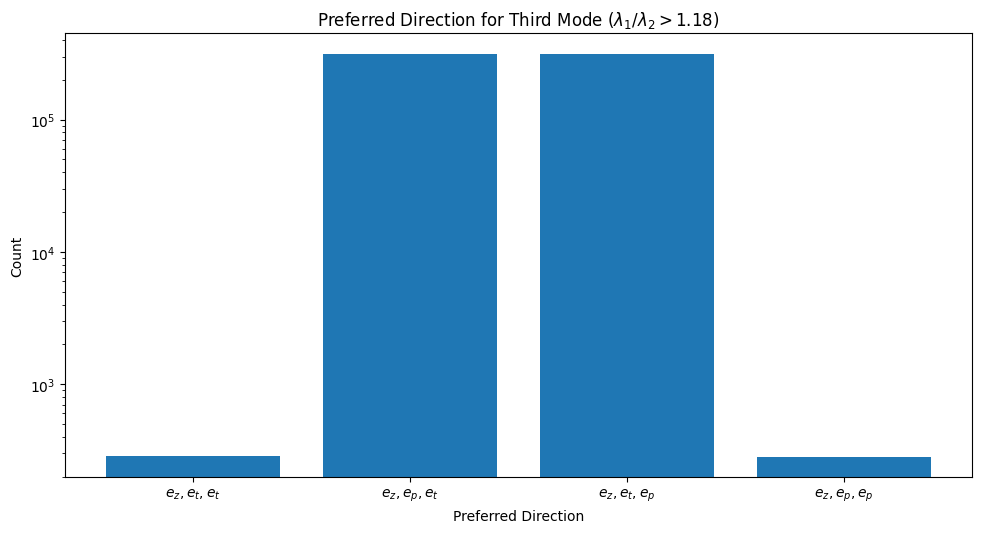

In [624]:
mask = (all_symmetricities >= THIRD_MODE_START) & (all_symmetricities <= THIRD_MODE_END) & (sorted_eigenvalues[:, 2]/sorted_eigenvalues[:, 1] > 1.18)
dist = np.sum(highest_base[mask] * np.array([3**2, 3**1, 3**0]), axis=-1)
keys = dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))
x = [f'${keys[k]}$' for k in sorted(keys.keys())]
heights = [np.sum(dist == k) for k in sorted(keys.keys())]
plt.figure(figsize=(10, 5))
plt.bar(x, heights)
plt.tight_layout()
plt.yscale('log')
plt.title('Preferred Direction for Third Mode ($λ_1/λ_2 > 1.18$)')
plt.xlabel('Preferred Direction')
plt.ylabel('Count')
print([round(x, 2) for x in np.array(heights)/np.sum(heights) * 100])
print(100*np.sum(mask)/np.sum((all_symmetricities >= THIRD_MODE_START) & (all_symmetricities <= THIRD_MODE_END)))

[0.08, 46.63, 0.06, 3.45, 46.28, 0.07, 3.36, 0.06]


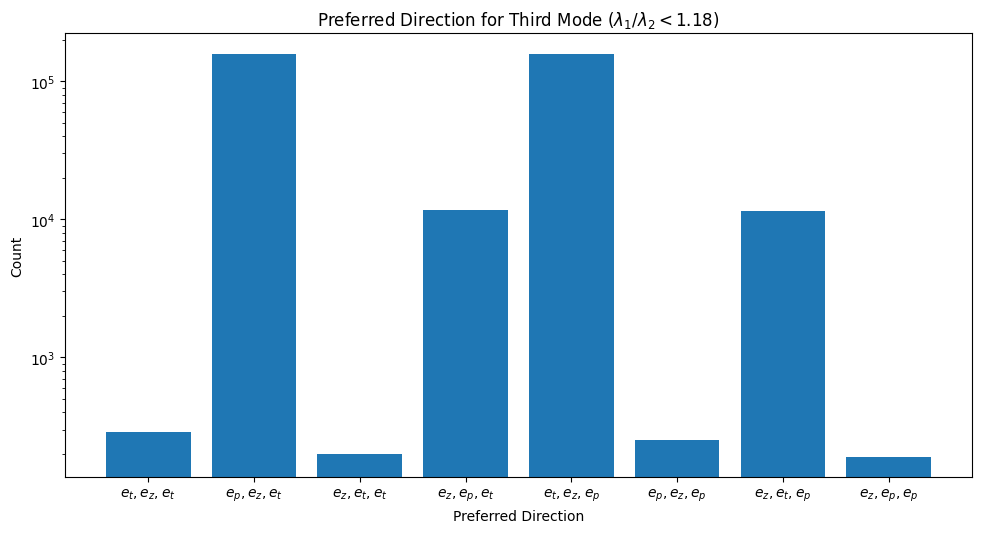

In [615]:
mask = (all_symmetricities >= THIRD_MODE_START) & (all_symmetricities <= THIRD_MODE_END) & (sorted_eigenvalues[:, 2]/sorted_eigenvalues[:, 1] <= 1.18)
dist = np.sum(highest_base[mask] * np.array([3**2, 3**1, 3**0]), axis=-1)
keys = dict(zip(np.unique(np.sort(dist)), [decode(i) for i in np.unique(np.sort(dist))]))
x = [f'${keys[k]}$' for k in sorted(keys.keys())]
heights = [np.sum(dist == k) for k in sorted(keys.keys())]
plt.figure(figsize=(10, 5))
plt.bar(x, heights)
plt.tight_layout()
plt.yscale('log')
plt.title('Preferred Direction for Third Mode ($λ_1/λ_2 < 1.18$)')
plt.xlabel('Preferred Direction')
plt.ylabel('Count')
print([round(x, 2) for x in np.array(heights)/np.sum(heights) * 100])

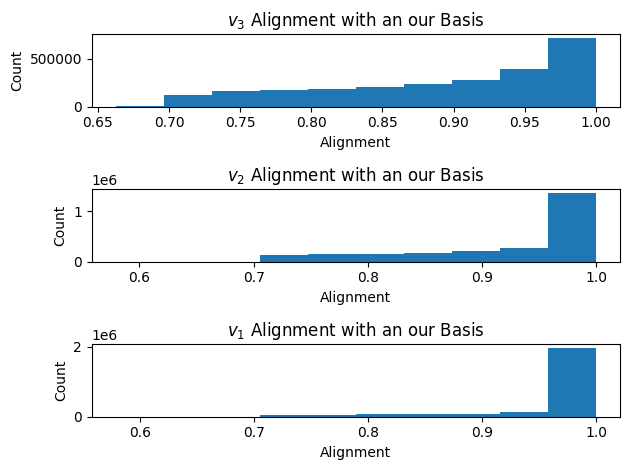

In [656]:
# Determe whether our chosen e_t, e_z, and e_p vectors are good
mask = all_symmetricities <= THIRD_MODE_END
largest_component = np.max(np.abs(directionally_sorted[mask]), axis=-1)
fig, axes = plt.subplots(3, 1)#, figsize=(5, 10))
axes[0].set_title('$v_3$ Alignment with an our Basis')
axes[0].hist(np.abs(largest_component[..., 0]))
axes[0].set_xlabel('Alignment')
axes[0].set_ylabel('Count')
axes[1].set_title('$v_2$ Alignment with an our Basis')
axes[1].hist(np.abs(largest_component[..., 1]))
axes[1].set_xlabel('Alignment')
axes[1].set_ylabel('Count')
axes[2].set_title('$v_1$ Alignment with an our Basis')
axes[2].hist(np.abs(largest_component[..., 2]))
axes[2].set_xlabel('Alignment')
axes[2].set_ylabel('Count')
fig.tight_layout()

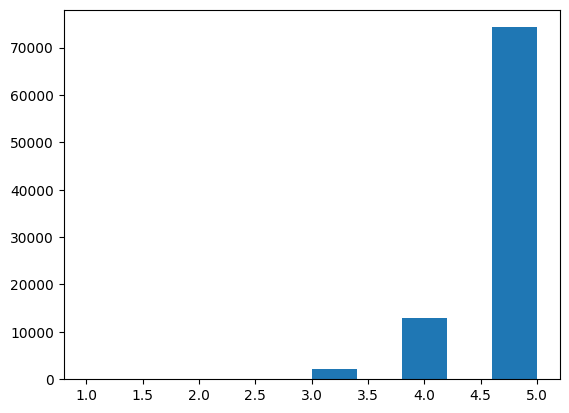

In [476]:
_ = plt.hist(all_nhits[(all_symmetricities >= 0.33) & (all_symmetricities <= 0.38)])

In [ ]:
plt.hist(all_nhits[(all_symmetricities > 0.3) & 

In [396]:
all_bases[:, :, 0]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [393]:
largest = np.argmax(np.abs(all_eigenvalues), axis=-1).shape

In [394]:
all_coefficients.shap

array([[-0.99637496, -0.0119854 , -0.08422143],
       [ 0.03471486,  0.01079282,  0.99933898],
       [-0.99955589, -0.0187672 ,  0.02314821],
       ...,
       [-0.15948112,  0.04182597,  0.98631454],
       [ 0.99948382, -0.02012359, -0.02504329],
       [ 0.005339  ,  0.01847799,  0.99981499]])

In [418]:
direction = np.argsort(np.abs(all_eigenvalues), axis=-1)[..., -1]

In [430]:
direction[:10]

array([0, 2, 0, 0, 2, 0, 0, 0, 0, 0])

In [427]:
all_coefficients[:10, :, 0]

array([[-0.99637496, -0.0119854 , -0.08422143],
       [ 0.03471486,  0.01079282,  0.99933898],
       [-0.99955589, -0.0187672 ,  0.02314821],
       [-0.99968582, -0.00477072, -0.02460754],
       [-0.00626786,  0.01026911,  0.99992764],
       [ 0.99898404, -0.02871329,  0.03473462],
       [ 0.99996591,  0.00197001, -0.00802149],
       [ 0.99982727, -0.01148554,  0.01461358],
       [-0.99986178,  0.01311066, -0.01022265],
       [ 0.99998176, -0.00484653, -0.00361225]])

In [431]:
np.take_along_axis(all_coefficients[..., 0], np.expand_dims(direction, -1), axis=-1)[:10]

array([[-0.99637496],
       [ 0.99933898],
       [-0.99955589],
       [-0.99968582],
       [ 0.99992764],
       [ 0.99898404],
       [ 0.99996591],
       [ 0.99982727],
       [-0.99986178],
       [ 0.99998176]])

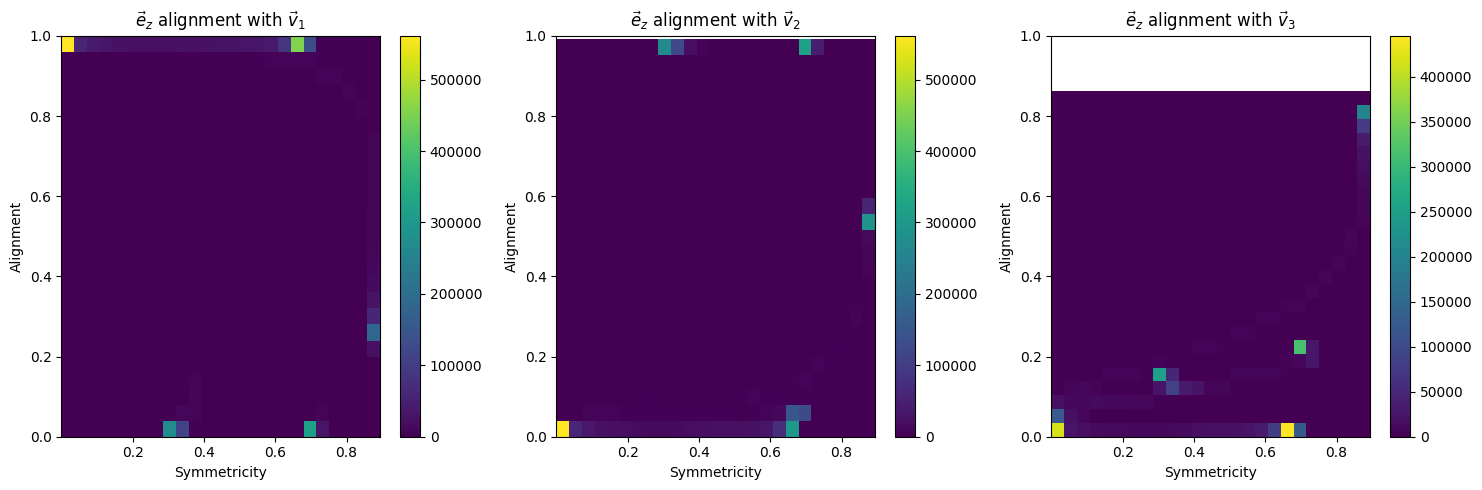

In [459]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15//3))
for i in range(3):
    #
    direction = np.argsort(np.abs(all_eigenvalues), axis=-1)[..., -(i+1)]

    alignment = np.abs(np.take_along_axis(all_coefficients[:, :, 0], np.expand_dims(direction, -1), axis=-1)).squeeze(-1)
    h = axes[i].hist2d(all_symmetricities, alignment, bins=25)
    axes[i].set_xlabel('Symmetricity')
    axes[i].set_ylabel('Alignment')
    fig.colorbar(h[3], ax=axes[i])
    axes[i].set_ylim(0, 1.0)
    axes[i].set_title(r'$\vec{e}_z$ alignment with $\vec{v}_{' + str(i+1) + '}$')


fig.tight_layout()

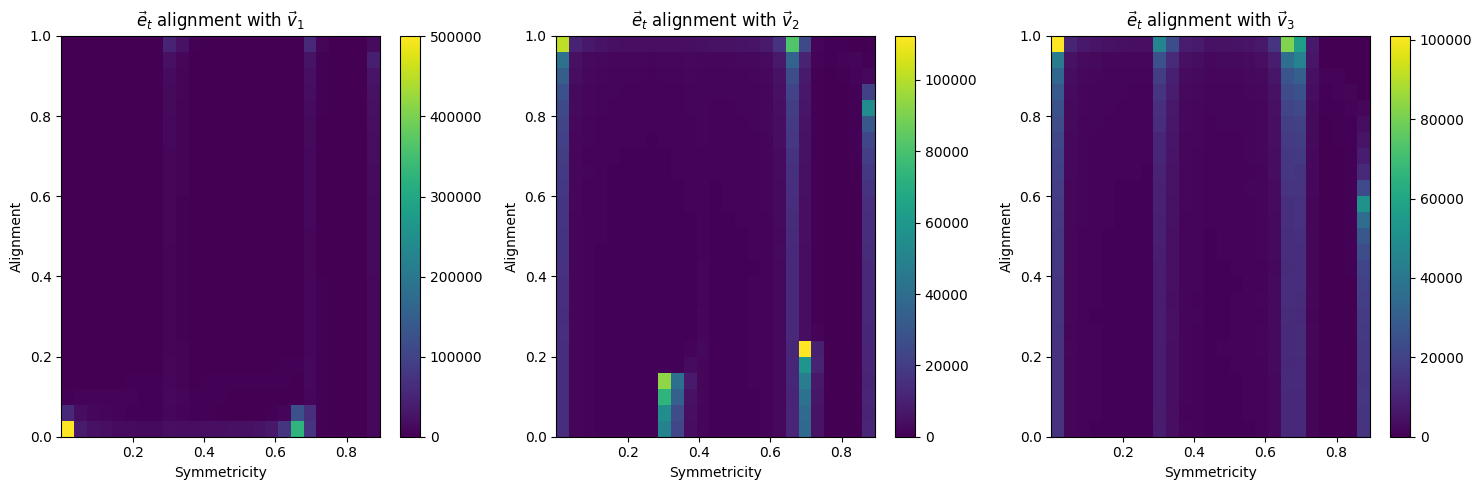

In [460]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15//3))
for i in range(3):
    #
    direction = np.argsort(np.abs(all_eigenvalues), axis=-1)[..., -(i+1)]

    alignment = np.abs(np.take_along_axis(all_coefficients[:, :, 1], np.expand_dims(direction, -1), axis=-1)).squeeze(-1)
    h = axes[i].hist2d(all_symmetricities, alignment, bins=25)
    axes[i].set_xlabel('Symmetricity')
    axes[i].set_ylabel('Alignment')
    fig.colorbar(h[3], ax=axes[i])
    axes[i].set_ylim(0, 1.0)
    #axes[i].set_title(r'$\vec{e}_t$ alignment with $\vec{v}_i$')
    axes[i].set_title(r'$\vec{e}_t$ alignment with $\vec{v}_{' + str(i+1) + '}$')


fig.tight_layout()

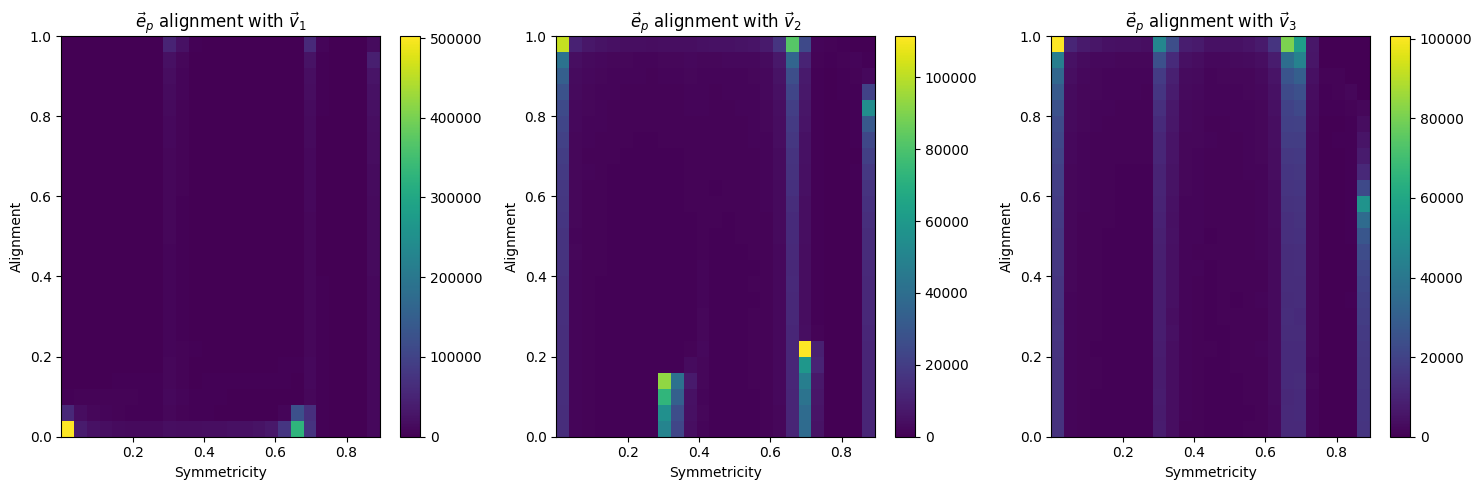

In [461]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15//3))
for i in range(3):
    #
    direction = np.argsort(np.abs(all_eigenvalues), axis=-1)[..., -(i+1)]

    alignment = np.abs(np.take_along_axis(all_coefficients[:, :, 2], np.expand_dims(direction, -1), axis=-1)).squeeze(-1)
    h = axes[i].hist2d(all_symmetricities, alignment, bins=25)
    axes[i].set_xlabel('Symmetricity')
    axes[i].set_ylabel('Alignment')
    fig.colorbar(h[3], ax=axes[i])
    axes[i].set_ylim(0, 1.0)
    axes[i].set_title(r'$\vec{e}_p$ alignment with $\vec{v}_{' + str(i+1) + '}$')


fig.tight_layout()

In [477]:
all_coefficients.shape

(2939413, 3, 3)

In [378]:
np.max(all_eigenvalues, axis=-1).shape

(2939413,)

In [ ]:
all_symetricities.shape

In [373]:
all_eigenvalues.shape

(2939413, 3)

In [338]:
all_coefficients.shape

(2939413, 3, 3)

In [339]:
all_eigenvectors.shapeb

(2939413, 3, 3)

In [358]:
index = 100

In [359]:
all_eigenvectors[index]

array([[ 0.65091884,  0.72090375, -0.23791265],
       [ 0.6761361 , -0.40804043,  0.613468  ],
       [-0.34517342,  0.5601792 ,  0.75303024]], dtype=float32)

In [360]:
(all_coefficients[index] @ all_bases[index].T).T

array([[ 0.65091884,  0.72090375, -0.23791265],
       [ 0.67613608, -0.40804043,  0.61346799],
       [-0.34517342,  0.56017917,  0.75303024]])

In [363]:
all_coefficients[0, 0]

array([-0.99637496, -0.01034906,  0.08443811])

In [364]:
all_eigenvectors[0, :, 0]

array([ 0.03466469,  0.07768692, -0.99637496], dtype=float32)

In [ ]:
all_basis[0, :, 0]

In [ ]:
len(all_coefficients)

In [230]:
all_eigenvectors = np.concatenate(all_eigenvectors[:3], axis=1)

In [233]:
all_eigenvectors[0]

array([[ 0.03466469, -0.9613051 , -0.2732963 ],
       [ 0.07768692,  0.2752251 , -0.9582358 ],
       [-0.99637496, -0.0119854 , -0.08422143]], dtype=float32)

In [236]:
e_vec[0]

array([[ 0.03466469, -0.9613051 , -0.2732963 ],
       [ 0.07768692,  0.2752251 , -0.9582358 ],
       [-0.99637496, -0.0119854 , -0.08422143]], dtype=float32)

In [237]:
all_eigenvectors[0, 0]

array([ 0.03466469, -0.9613051 , -0.2732963 ], dtype=float32)

In [239]:
zs[0][0, 0] * all_coefficients[0, 0, 0] + tangents[0][0, 0] * all_coefficients[1, 0, 0] + vs[0][0, 0] * all_coefficients[2, 0, 0]

array([ 0.03466469,  0.07768692, -0.99637496])

In [290]:
zs[1][0, 0] * all_coefficients[0, 0, 1] + tangents[1][0, 0] * all_coefficients[1, 0, 1] + vs[1][0, 0] * all_coefficients[2, 0, 1]

array([ 0.00338926, -0.03619557,  0.99933898])

In [243]:
all_eigenvectors[0][]

array([[ 0.03466469, -0.9613051 , -0.2732963 ],
       [ 0.07768692,  0.2752251 , -0.9582358 ],
       [-0.99637496, -0.0119854 , -0.08422143]], dtype=float32)

In [291]:
index = 0

In [292]:
b = np.stack([zs[index], tangents[index], vs[index]], axis=-2).reshape(-1, 3, 3)

In [293]:
b.shape

(25, 3, 3)

In [294]:
all_coefficients[..., :b.shape[0]].shape

(3, 3, 25)

In [310]:
np.einsum('ebh,hef->hbf', all_coefficients[..., :b.shape[0]], b.reshape(-1, 3, 3)).transpose(0, 2, 1)[:5]

array([[[ 3.46646868e-02, -9.61305082e-01, -2.73296297e-01],
        [ 7.76869208e-02,  2.75225103e-01, -9.58235800e-01],
        [-9.96374965e-01, -1.19853979e-02, -8.42214301e-02]],

       [[ 3.02056223e-02, -7.77877390e-01, -6.27689719e-01],
        [ 2.02293582e-02,  6.28323436e-01, -7.77689159e-01],
        [ 9.99338984e-01,  1.07928244e-02,  3.47148590e-02]],

       [[ 1.34074762e-02, -9.76938486e-01, -2.13099688e-01],
        [-2.66136639e-02,  2.12694690e-01, -9.76756215e-01],
        [-9.99555886e-01, -1.87671985e-02,  2.31482144e-02]],

       [[-9.21292417e-03, -8.43070030e-01,  5.37724853e-01],
        [ 2.33112127e-02, -5.37782609e-01, -8.42761219e-01],
        [-9.99685824e-01, -4.77072317e-03, -2.46075355e-02]],

       [[ 5.71372744e-04,  8.77344728e-01,  4.79860306e-01],
        [ 1.20172445e-02,  4.79819715e-01, -8.77284825e-01],
        [ 9.99927640e-01, -6.26785541e-03,  1.02691101e-02]]])

In [315]:
e_vec[np.argsort(e_val, axis=-1)].shape

(22, 3, 3, 3)

In [329]:
np.take_along_axis(e_vec, np.expand_dims(np.argsort(-e_val, axis=-1), -1).repeat(3, 2), axis=1)[:5]

array([[[ 3.46646868e-02, -9.61305082e-01, -2.73296297e-01],
        [ 7.76869208e-02,  2.75225103e-01, -9.58235800e-01],
        [-9.96374965e-01, -1.19853979e-02, -8.42214301e-02]],

       [[ 3.47148590e-02,  1.07928244e-02,  9.99338984e-01],
        [-7.77689159e-01,  6.28323436e-01,  2.02293582e-02],
        [-6.27689719e-01, -7.77877390e-01,  3.02056223e-02]],

       [[ 1.34074762e-02, -9.76938486e-01, -2.13099688e-01],
        [-2.66136639e-02,  2.12694690e-01, -9.76756215e-01],
        [-9.99555886e-01, -1.87671985e-02,  2.31482144e-02]],

       [[-9.21292417e-03, -8.43070030e-01,  5.37724853e-01],
        [ 2.33112127e-02, -5.37782609e-01, -8.42761219e-01],
        [-9.99685824e-01, -4.77072317e-03, -2.46075355e-02]],

       [[-6.26785541e-03,  1.02691101e-02,  9.99927640e-01],
        [ 8.77344728e-01,  4.79860306e-01,  5.71372744e-04],
        [ 4.79819715e-01, -8.77284825e-01,  1.20172445e-02]]],
      dtype=float32)

In [328]:
e_val

array([[1.0454886e-03, 1.5401872e-04, 1.4411907e-04],
       [7.2590017e-05, 1.9243546e-04, 1.4631229e-03],
       [1.1873235e-03, 1.1325960e-04, 8.1843209e-05],
       [9.9562830e-04, 1.2552530e-04, 1.2006227e-04],
       [1.9008428e-04, 1.6986915e-04, 1.2709973e-03],
       [1.0271874e-03, 2.0552325e-05, 1.8621664e-05],
       [1.4542231e-03, 1.6397818e-05, 1.1291180e-05],
       [1.5976088e-03, 1.2381858e-05, 8.3668956e-06],
       [2.0715662e-03, 1.5632946e-05, 1.2851287e-05],
       [1.9654927e-03, 2.6377056e-05, 2.1965619e-05],
       [2.1448825e-03, 2.2676412e-03, 2.3513646e-03],
       [2.9322950e-03, 1.3615725e-03, 2.1114287e-03],
       [2.2051968e-03, 1.7590654e-03, 1.7368684e-03],
       [1.2705199e-03, 5.4774148e-04, 5.1674858e-04],
       [2.8529583e-04, 7.0865604e-04, 1.5564563e-03],
       [4.8279198e-04, 3.5095378e-04, 1.2848130e-03],
       [1.0762541e-03, 4.3751972e-04, 4.2820215e-04],
       [5.4327678e-04, 5.0281035e-04, 1.4111660e-03],
       [1.3725776e-03, 7.290

In [318]:
e_vec.shape

(22, 3, 3)

In [210]:
e_val, e_vec = np.linalg.eig(sigmas[0].reshape(-1, 3, 3)[good_hits[0].reshape(-1)])

In [214]:
np.argsort(e_val[0])

array([2, 1, 0])

In [223]:
e_vec[0, :, 2] @ vs[0].reshape(-1, 3)[good_hits[0].reshape(-1)][0]

-0.9619703130040901

In [219]:
tangents[0].reshape(-1, 3)[good_hits[0].reshape(-1)][0]

array([ 0.85685744, -0.51555342,  0.        ])

In [227]:
np.einsum('hf, hif->hi', zs[0].reshape(-1, 3)[good_hits[0].reshape(-1)], e_vec)[0]

array([-0.2732963 , -0.9582358 , -0.08422143])

In [228]:
all_coefficients[:, :, 0]

array([[0.99637496, 0.0119854 , 0.08422143],
       [0.01034906, 0.96559465, 0.25984578],
       [0.08443811, 0.25977545, 0.96197031]])

In [144]:
norms = np.sum(all_coefficients**2, axis=0)

In [152]:
# all_coefficients: (base vector_coeff, eigenvector, index)

array([0.99999996, 0.99999993, 1.00000002, ..., 0.99999999, 1.00000002,
       1.00000001])

In [155]:
all_coefficients[:, 0, :].T.shape

(2939413, 3)

In [156]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(all_coefficients[:, 0, :].T)

PCA(n_components=3)

In [158]:
np.mean(all_coefficients[:, 0, :].T, axis=0)

array([0.64746519, 0.27094536, 0.27118626])

In [159]:
np.mean(all_coefficients[:, 1, :].T, axis=0)

array([0.35218722, 0.48469006, 0.48509018])

In [160]:
np.mean(all_coefficients[:, 2, :].T, axis=0)

array([0.17563605, 0.60243493, 0.60166361])

In [143]:
for index in range(all_coefficients.shape[-1]):
    for i in range(3):
        n = all_coefficients[0, 0, index]**2 + all_coefficients[1, 0, index]**2 + all_coefficients[2, 0, index]**2
        if not np.isclose(n, 1.0):
            print(index)

KeyboardInterrupt: 

1.0000000356984036

In [124]:
all_coefficients[1, 0, 0]

0.010349063391857226

In [125]:
all_coefficients[2, 0, 0]

0.08443811374736081

In [114]:
all_coeff

TypeError: tuple indices must be integers or slices, not tuple

Text(0.5, 1.0, 'Histogram of Trigger Symmetricites and Alignments')

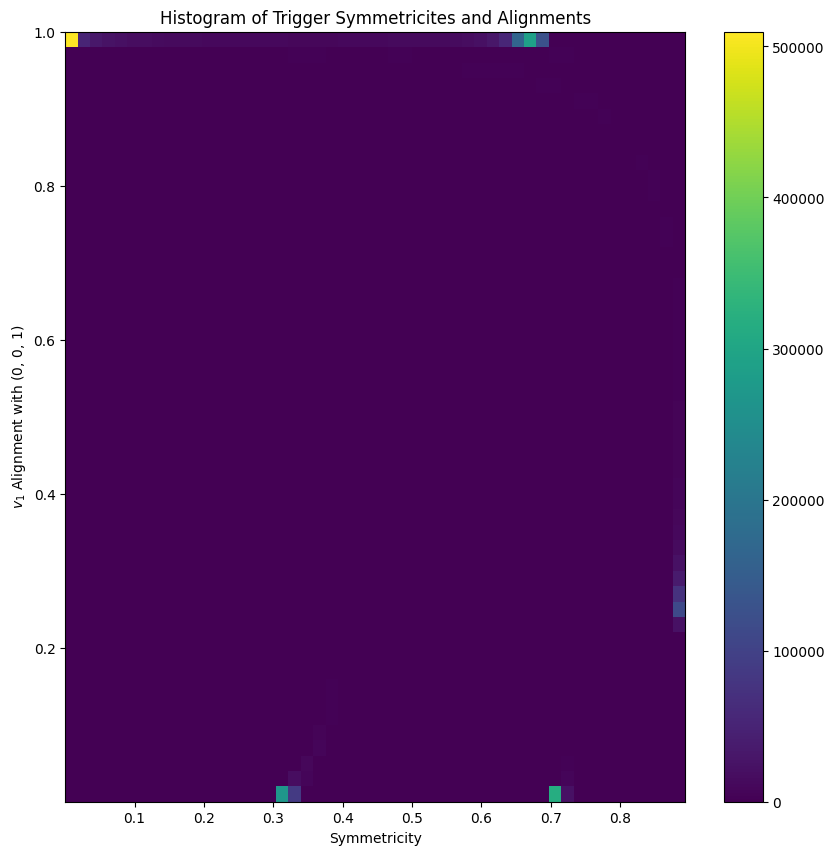

In [46]:
alignments = []
symmetricities = []
for track, sigma, momentum, hits_mask, trigger_mask in zip(tracks, sigmas, vs, good_hits, tt_tracks):
    #print(sigma.shape)
    #m = np.repeat(np.expand_dims(momentum, 1), 5, axis=1).reshape(-1, 3)
    m = momentum.reshape(-1, 3)
    m = np.zeros(m.shape)
    m[..., -1] = 1
    hits_mask = hits_mask.reshape(-1)
    trigger_mask = trigger_mask.reshape(-1)
    mask = hits_mask # * trigger_mask
    all_hits = track[..., :15].reshape(-1, 3)
    hits = all_hits[mask]
    m = m[mask]
    sigma = sigma.reshape(-1, 3, 3)[mask]
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    m /= np.expand_dims(np.linalg.norm(m, axis=-1), -1)
    alignment = np.einsum('hf,hfi->hi', m, eigenvectors)
    preferred_direction = np.expand_dims(np.argsort(eigenvalues, axis=-1)[..., -1], -1)
    alignments.append(np.abs(np.take_along_axis(alignment, preferred_direction, -1)))
    symmetricities.append(np.prod(eigenvalues/np.expand_dims(np.max(eigenvalues, axis=-1), -1), -1))
trigger_alignments = np.concatenate(alignments, axis=0)
trigger_symmetricities = np.concatenate(symmetricities, axis=0)
plt.figure(figsize=(10, 10))
h = plt.hist2d(np.squeeze(trigger_symmetricities), np.squeeze(trigger_alignments), bins=50)#, norm=colors.LogNorm())
plt.colorbar(h[3])
plt.xlabel('Symmetricity')
plt.ylabel('$v_1$ Alignment with (0, 0, 1)')
plt.title('Histogram of Trigger Symmetricites and Alignments')

Text(0.5, 1.0, 'Histogram of Trigger Symmetricites and Alignments')

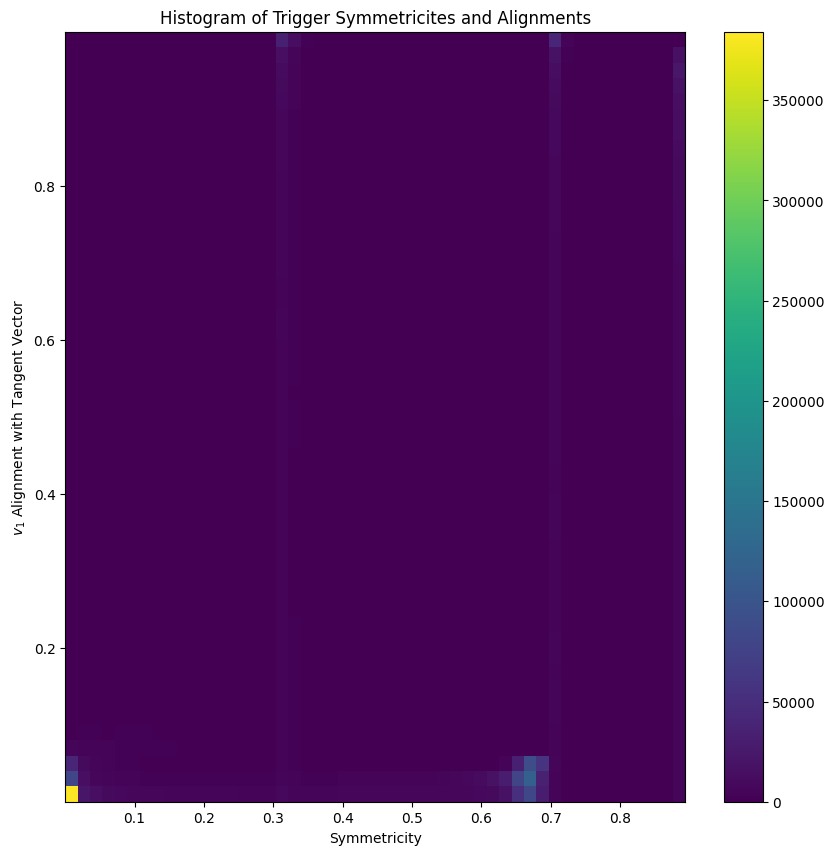

In [51]:
alignments = []
symmetricities = []
for track, sigma, momentum, hits_mask, trigger_mask in zip(tracks, sigmas, tangents, good_hits, tt_tracks):
    #print(sigma.shape)
    #m = np.repeat(np.expand_dims(momentum, 1), 5, axis=1).reshape(-1, 3)
    m = momentum.reshape(-1, 3)
    hits_mask = hits_mask.reshape(-1)
    trigger_mask = trigger_mask.reshape(-1)
    mask = hits_mask # * trigger_mask
    all_hits = track[..., :15].reshape(-1, 3)
    hits = all_hits[mask]
    m = m[mask]
    sigma = sigma.reshape(-1, 3, 3)[mask]
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    m /= np.expand_dims(np.linalg.norm(m, axis=-1), -1)
    alignment = np.einsum('hf,hfi->hi', m, eigenvectors)
    preferred_direction = np.expand_dims(np.argsort(eigenvalues, axis=-1)[..., -1], -1)
    alignments.append(np.abs(np.take_along_axis(alignment, preferred_direction, -1)))
    symmetricities.append(np.prod(eigenvalues/np.expand_dims(np.max(eigenvalues, axis=-1), -1), -1))
trigger_alignments = np.concatenate(alignments, axis=0)
trigger_symmetricities = np.concatenate(symmetricities, axis=0)
plt.figure(figsize=(10, 10))
h = plt.hist2d(np.squeeze(trigger_symmetricities), np.squeeze(trigger_alignments), bins=50)#, norm=colors.LogNorm())
plt.colorbar(h[3])
plt.xlabel('Symmetricity')
plt.ylabel('$v_1$ Alignment with Tangent Vector')
plt.title('Histogram of Trigger Symmetricites and Alignments')

Text(0.5, 1.0, 'Histogram of Trigger Symmetricites and Alignments')

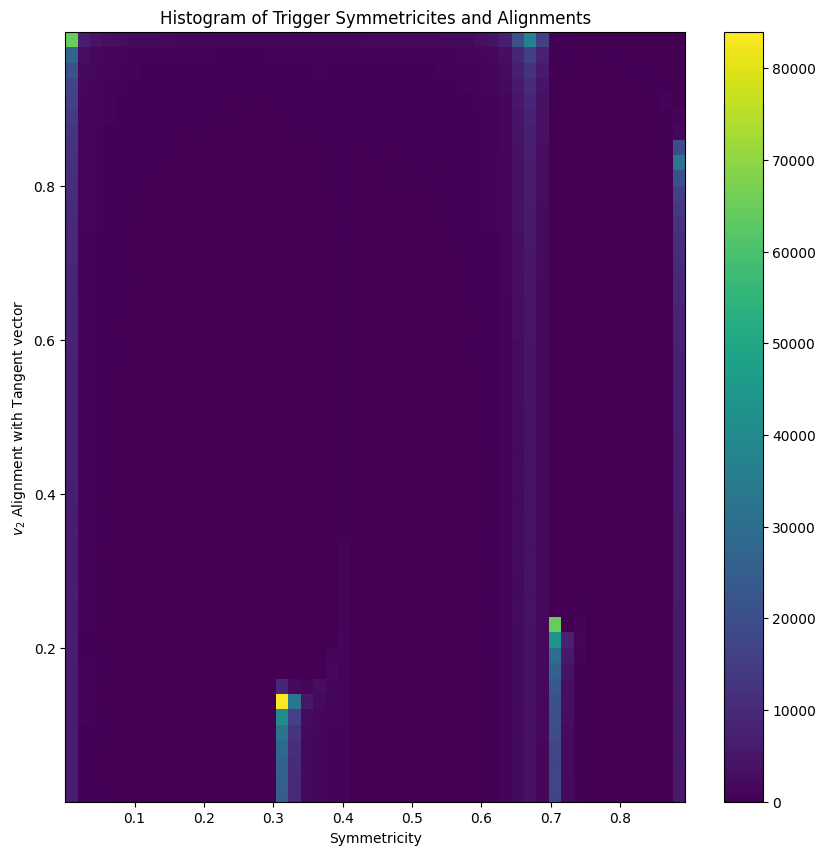

In [47]:
alignments = []
symmetricities = []
for track, sigma, momentum, hits_mask, trigger_mask in zip(tracks, sigmas, tangents, good_hits, tt_tracks):
    #print(sigma.shape)
    #m = np.repeat(np.expand_dims(momentum, 1), 5, axis=1).reshape(-1, 3)
    m = momentum.reshape(-1, 3)
    hits_mask = hits_mask.reshape(-1)
    trigger_mask = trigger_mask.reshape(-1)
    mask = hits_mask # * trigger_mask
    all_hits = track[..., :15].reshape(-1, 3)
    hits = all_hits[mask]
    m = m[mask]
    sigma = sigma.reshape(-1, 3, 3)[mask]
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    m /= np.expand_dims(np.linalg.norm(m, axis=-1), -1)
    alignment = np.einsum('hf,hfi->hi', m, eigenvectors)
    preferred_direction = np.expand_dims(np.argsort(eigenvalues, axis=-1)[..., -2], -1)
    alignments.append(np.abs(np.take_along_axis(alignment, preferred_direction, -1)))
    symmetricities.append(np.prod(eigenvalues/np.expand_dims(np.max(eigenvalues, axis=-1), -1), -1))
trigger_alignments = np.concatenate(alignments, axis=0)
trigger_symmetricities = np.concatenate(symmetricities, axis=0)
plt.figure(figsize=(10, 10))
h = plt.hist2d(np.squeeze(trigger_symmetricities), np.squeeze(trigger_alignments), bins=50)#, norm=colors.LogNorm())
plt.colorbar(h[3])
plt.xlabel('Symmetricity')
plt.ylabel('$v_2$ Alignment with Tangent vector')
plt.title('Histogram of Trigger Symmetricites and Alignments')

Text(0.5, 1.0, 'Histogram of Trigger Symmetricites and Alignments')

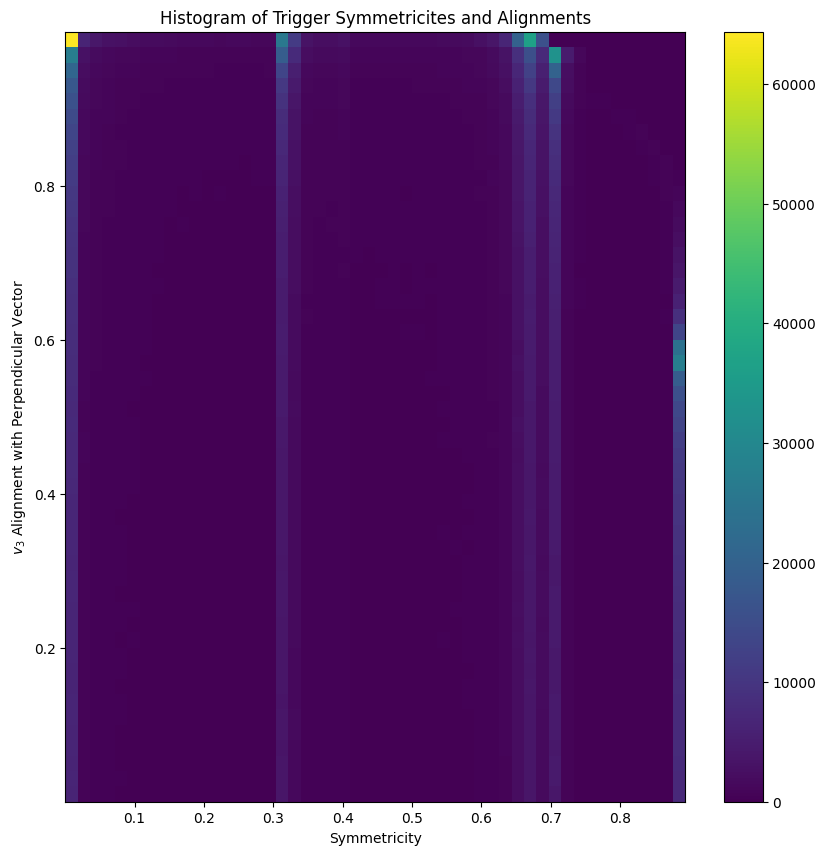

In [48]:
alignments = []
symmetricities = []
for track, sigma, momentum, hits_mask, trigger_mask in zip(tracks, sigmas, vs, good_hits, tt_tracks):
    #print(sigma.shape)
    #m = np.repeat(np.expand_dims(momentum, 1), 5, axis=1).reshape(-1, 3)
    m = momentum.reshape(-1, 3)
    hits_mask = hits_mask.reshape(-1)
    trigger_mask = trigger_mask.reshape(-1)
    mask = hits_mask # * trigger_mask
    all_hits = track[..., :15].reshape(-1, 3)
    hits = all_hits[mask]
    m = m[mask]
    sigma = sigma.reshape(-1, 3, 3)[mask]
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    m /= np.expand_dims(np.linalg.norm(m, axis=-1), -1)
    alignment = np.einsum('hf,hfi->hi', m, eigenvectors)
    preferred_direction = np.expand_dims(np.argsort(eigenvalues, axis=-1)[..., -3], -1)
    alignments.append(np.abs(np.take_along_axis(alignment, preferred_direction, -1)))
    symmetricities.append(np.prod(eigenvalues/np.expand_dims(np.max(eigenvalues, axis=-1), -1), -1))
trigger_alignments = np.concatenate(alignments, axis=0)
trigger_symmetricities = np.concatenate(symmetricities, axis=0)
plt.figure(figsize=(10, 10))
h = plt.hist2d(np.squeeze(trigger_symmetricities), np.squeeze(trigger_alignments), bins=50)#, norm=colors.LogNorm())
plt.colorbar(h[3])
plt.xlabel('Symmetricity')
plt.ylabel('$v_3$ Alignment with Perpendicular Vector')
plt.title('Histogram of Trigger Symmetricites and Alignments')

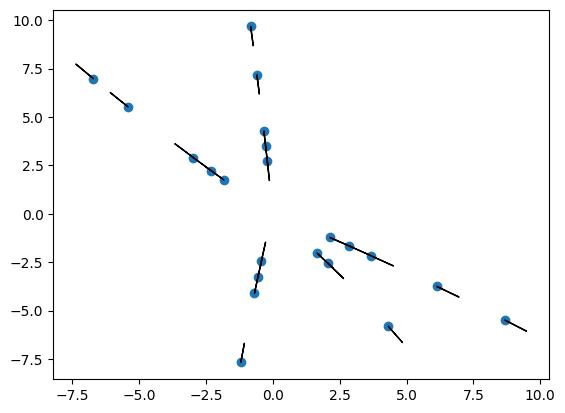

In [28]:
plt.scatter(event_hits[0][..., 0].reshape(-1)[good_hits[0].reshape(-1)], event_hits[0][..., 1].reshape(-1)[good_hits[0].reshape(-1)])
for h, a, g in zip(event_hits[0].reshape(-1, 3), tangents[0].reshape(-1, 3), good_hits[0].reshape(-1)):
    if g:
        plt.arrow(h[0], h[1], a[0], a[1])

In [24]:
tangents[0].shape

(5, 5, 3)

Text(0.5, 1.0, 'Histogram of Trigger Symmetricites and Alignments')

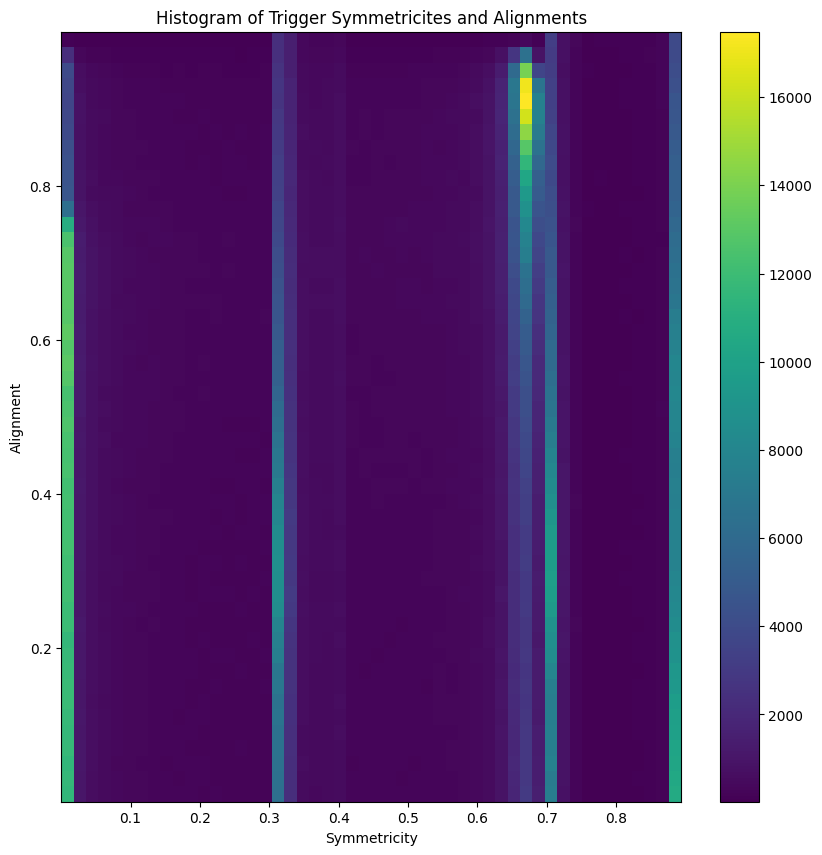

In [10]:
alignments = []
symmetricities = []
for track, sigma, momentum, hits_mask, trigger_mask in zip(tracks, sigmas, momentums, good_hits, tt_tracks):
    #print(sigma.shape)
    m = np.repeat(np.expand_dims(momentum, 1), 5, axis=1).reshape(-1, 3)
    #m = momentum.reshape(-1, 3)
    hits_mask = hits_mask.reshape(-1)
    trigger_mask = trigger_mask.reshape(-1)
    mask = hits_mask # * trigger_mask
    all_hits = track[..., :15].reshape(-1, 3)
    hits = all_hits[mask]
    m = m[mask]
    sigma = sigma.reshape(-1, 3, 3)[mask]
    eigenvalues, eigenvectors = np.linalg.eig(sigma)
    m /= np.expand_dims(np.linalg.norm(m, axis=-1), -1)
    alignment = np.einsum('hf,hfi->hi', m, eigenvectors)
    preferred_direction = np.expand_dims(np.argmax(eigenvalues, axis=-1), -1)
    alignments.append(np.abs(np.take_along_axis(alignment, preferred_direction, -1)))
    symmetricities.append(np.prod(eigenvalues/np.expand_dims(np.max(eigenvalues, axis=-1), -1), -1))
trigger_alignments = np.concatenate(alignments, axis=0)
trigger_symmetricities = np.concatenate(symmetricities, axis=0)
plt.figure(figsize=(10, 10))
h = plt.hist2d(np.squeeze(trigger_symmetricities), np.squeeze(trigger_alignments), bins=50)#, norm=colors.LogNorm())
plt.colorbar(h[3])
plt.xlabel('Symmetricity')
plt.ylabel('Alignment')
plt.title('Histogram of Trigger Symmetricites and Alignments')

In [14]:
tangents[0]

array([[[ 0.85685744, -0.51555342,  0.        ],
        [ 0.85286062, -0.52213865,  0.        ],
        [ 0.84811781, -0.52980768,  0.        ],
        [ 0.8333324 , -0.5527722 ,  0.        ],
        [ 0.81715793, -0.57641385,  0.        ]],

       [[ 0.0811071 , -0.99670539,  0.        ],
        [ 0.08290678, -0.99655731,  0.        ],
        [ 0.08473502, -0.99640352,  0.        ],
        [ 0.09151882, -0.99580335,  0.        ],
        [ 0.09731891, -0.99525325,  0.        ]],

       [[ 0.61186859, -0.79095943,  0.        ],
        [ 0.60187413, -0.79859096,  0.        ],
        [ 0.65167833, -0.75849546,  0.        ],
        [ 0.5380088 , -0.84293922,  0.        ],
        [ 0.65167833, -0.75849546,  0.        ]],

       [[-0.70642751,  0.7077854 ,  0.        ],
        [-0.70179284,  0.71238109,  0.        ],
        [-0.69530605,  0.71871378,  0.        ],
        [-0.67014729,  0.74222814,  0.        ],
        [-0.65610843,  0.75466664,  0.        ]],

       [[ 0.

In [15]:
tangents[0].shape

(5, 5, 3)

In [17]:
hits.shape

torch.Size([75, 3])